In [12]:
from spacerocks import SpaceRock, Units

from astroquery.jplhorizons import Horizons

from astropy.time import Time
from astropy import units as u
from astropy.coordinates import SkyCoord

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
units = Units()
units.timescale = 'tdb' # JPL gives elements in TDB. This actually matters for precise ephemerides.
units.current()

Quantity             Unit           
---------------------------------------
distance             AU             
angle                deg            
timescale            tdb            
timeformat           None           
speed                AU / d         
size                 km             
density              g / cm3        
mass                 kg             
ra                   deg            
dec                  deg            


In [14]:
rock = SpaceRock(x=6.524613938694123E+00, 
                 y=-7.482909836342731E+00, 
                 z=-1.333023019165556E-01, 
                 vx=7.135874422162411E-04, 
                 vy=3.978434999231591E-03, 
                 vz=-6.985401192360585E-05, 
                 epoch=2459467.5, 
                 name='Titan',
                 origin='ssb',
                 units=units)

In [15]:
startdate = Time('2020-01-01', scale='utc', format='iso')
testdates = Time(np.arange(startdate.jd, startdate.jd + 2 * 365.25, 1), scale='utc', format='jd')

In [16]:
units.timescale = 'utc'
prop, planets, sim = rock.propagate(epochs=testdates.jd, model=2, units=units)

/usr/local/bin/anaconda/envs/spacerocks/lib/python3.9/site-packages/rebound/simulation.py:716: RuntimeWarning: WHFast convergence issue. Timestep is larger than at least one orbital period.
  warnings.warn(msg[1:], RuntimeWarning)


In [17]:
saturn = planets[planets.name == 'Saturn']
obs = prop.observe(obscode='W84')
#obs = saturn.observe(obscode='W84')

In [18]:
rock_id = 'Titan'
ephem_Horizons = Horizons(id='606',
                          id_type='majorbody',
                          location='W84',
                          epochs={'start':testdates[0].iso, 
                                  'stop':testdates[-1].iso, 
                                  'step':'1d'}).ephemerides()

elem_Horizons = Horizons(id='606', 
                         id_type='majorbody',
                         location='@0',
                         epochs={'start':testdates[0].iso, 
                                 'stop':testdates[-1].iso, 
                                 'step':'1d'}).vectors(refplane='ecliptic')

In [19]:
dx = elem_Horizons['x'] - prop.x
dy = elem_Horizons['y'] - prop.y
dz = elem_Horizons['z'] - prop.z

dr = np.sqrt(dx*dx + dy*dy + dz*dz)

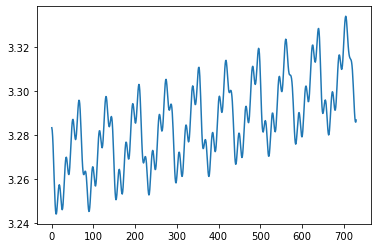

In [20]:
plt.plot(dr)

In [10]:
pos_Horizons = SkyCoord(ephem_Horizons['RA'], ephem_Horizons['DEC'], frame='icrs', unit=(u.deg, u.deg))
pos_pred = SkyCoord(obs.ra.deg, obs.dec.deg, frame='icrs', unit=(u.deg, u.deg))
sep = pos_pred.separation(pos_Horizons)

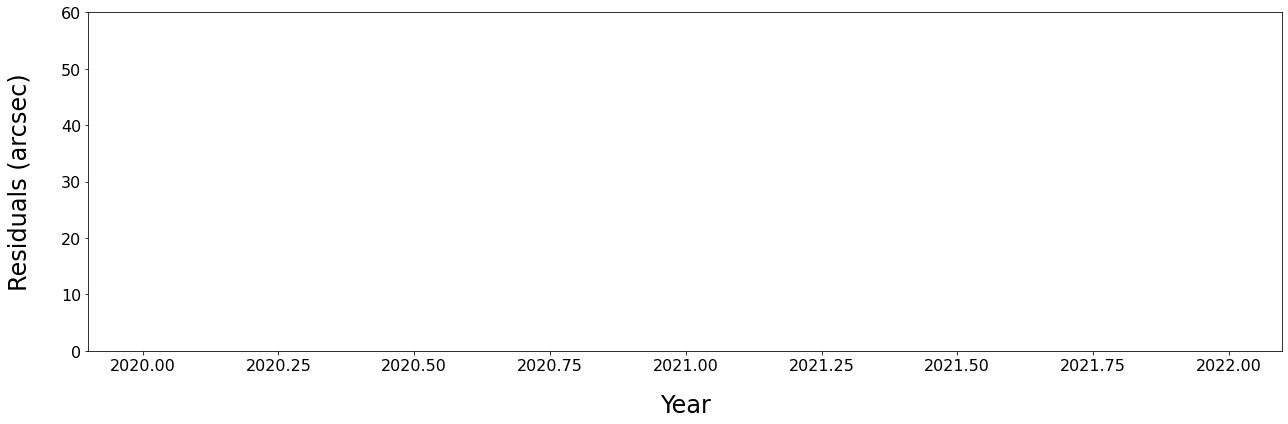

In [11]:
fig, ax = plt.subplots(figsize=(18, 6))

ax.scatter(prop.epoch.decimalyear, sep.arcsec, color='black', s=1)

ax.tick_params(labelsize=16)
ax.set_xlabel('Year', fontsize=24, labelpad=20)
ax.set_ylabel('Residuals (arcsec)', fontsize=24, labelpad=30)
ax.set_ylim(bottom=0, top=60)
fig.tight_layout()

In [70]:
np.median(sep.arcsec)

35.615780202745086

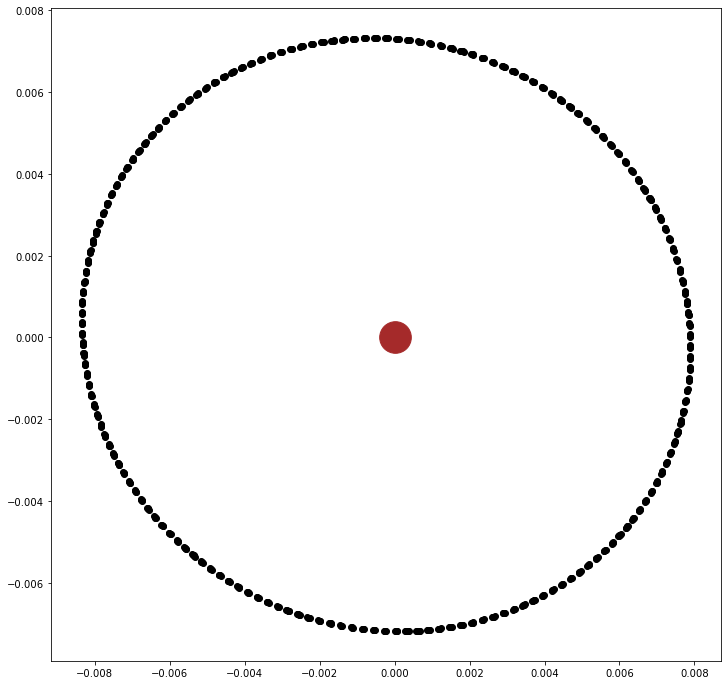

In [62]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(prop.x - saturn.x, prop.y - saturn.y, color='black')
ax.scatter(0, 0, color='brown', s=1000)